# Preparing data for eeg-ica-annotation Tool


* Preprocess the data
* Apply ICA
* Use Django API to save the data to the tool's db

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
%matplotlib notebook

mne.io includes the funtions for different EEG-record formats

Optional To Do
File formats (EDF, FIFF)

In [181]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R07.edf"

--2020-11-14 13:18:27--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R07.edf
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2596896 (2.5M) [application/octet-stream]
Saving to: ‘S003R07.edf’

S003R07.edf         100%[===================>]   2.48M  2.14MB/s    in 1.2s    

2020-11-14 13:18:29 (2.14 MB/s) - ‘S003R07.edf’ saved [2596896/2596896]



In [182]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R07.edf.event"

--2020-11-14 13:18:29--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R07.edf.event
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638 [text/plain]
Saving to: ‘S003R07.edf.event’

S003R07.edf.event   100%[===================>]     638  --.-KB/s    in 0s      

2020-11-14 13:18:30 (60.8 MB/s) - ‘S003R07.edf.event’ saved [638/638]



In [183]:
sample = mne.io.read_raw_edf('S003R06.edf', verbose=False, preload=True)

Get some info about a record

In [184]:
sample.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [185]:
# Sampling frequency
sample.info['sfreq']

160.0

In [186]:
# Length in seconds
len(sample) / sample.info['sfreq']

125.0

In [187]:
# Number of channels
len(sample.ch_names)

64

## Channel selection and adding a montage

In [188]:
sample.ch_names[:3]

['Fc5.', 'Fc3.', 'Fc1.']

In [189]:
ch_map = {ch: ch.strip('.') for ch in sample.ch_names}
sample.rename_channels(ch_map)

<RawEDF | S003R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [190]:
sample.ch_names[:3]

['Fc5', 'Fc3', 'Fc1']

In [191]:
# 19 channels from 10-20. no A1 and A2 here
# Be careful. Pure 10-20 labeling differs from high-resolution montages
# In MNE, 10-20 montage is actually an extended high-resulution version of 10-20
# FYI, mapping from pure 10-20 to high-resolution versions
# T3 = T7
# T4 = T8
# T5 = P7
# T6 = P8

channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [192]:
sample_1020 = sample.copy().pick_channels(channels_to_use)

# check that everything is OK
assert len(channels_to_use) == len(sample_1020.ch_names)

In [193]:
ch_map = {ch.lower(): ch for ch in sample_1020.ch_names}

In [194]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names)

94

In [195]:
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]

In [196]:
sample_1020.set_montage(ten_twenty_montage)

<RawEDF | S003R06.edf, 19 x 20000 (125.0 s), ~3.0 MB, data loaded>

### Band-pass filtering

It's better to remove low-freq components < 1 Hz and high-freq > 50Hz (non-informative for EEG)

Let's use 4-th order Butterworth filter (default IIR filter)

In [197]:
sample_1020.filter(l_freq=1, h_freq=50, method='iir')

<RawEDF | S003R06.edf, 19 x 20000 (125.0 s), ~3.0 MB, data loaded>

### Average referencing

In [198]:
sample_1020 = mne.set_eeg_reference(sample_1020, 'average')[0]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<IPython.core.display.Javascript object>


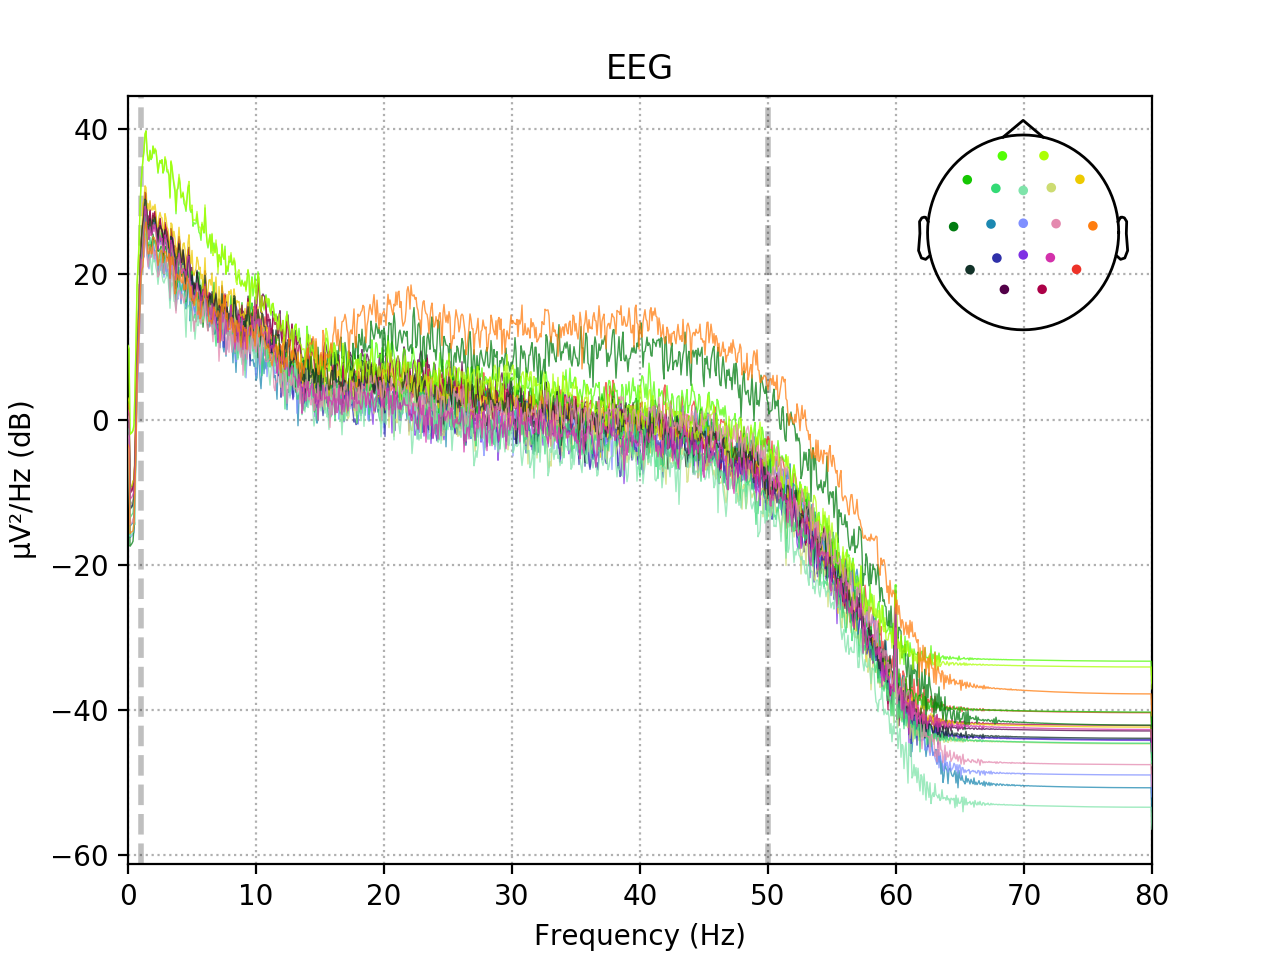

In [199]:
# Plot psd after filtering

# YOUR CODE HERE

sample_1020.plot_psd();

### Plot EEG signals

<IPython.core.display.Javascript object>


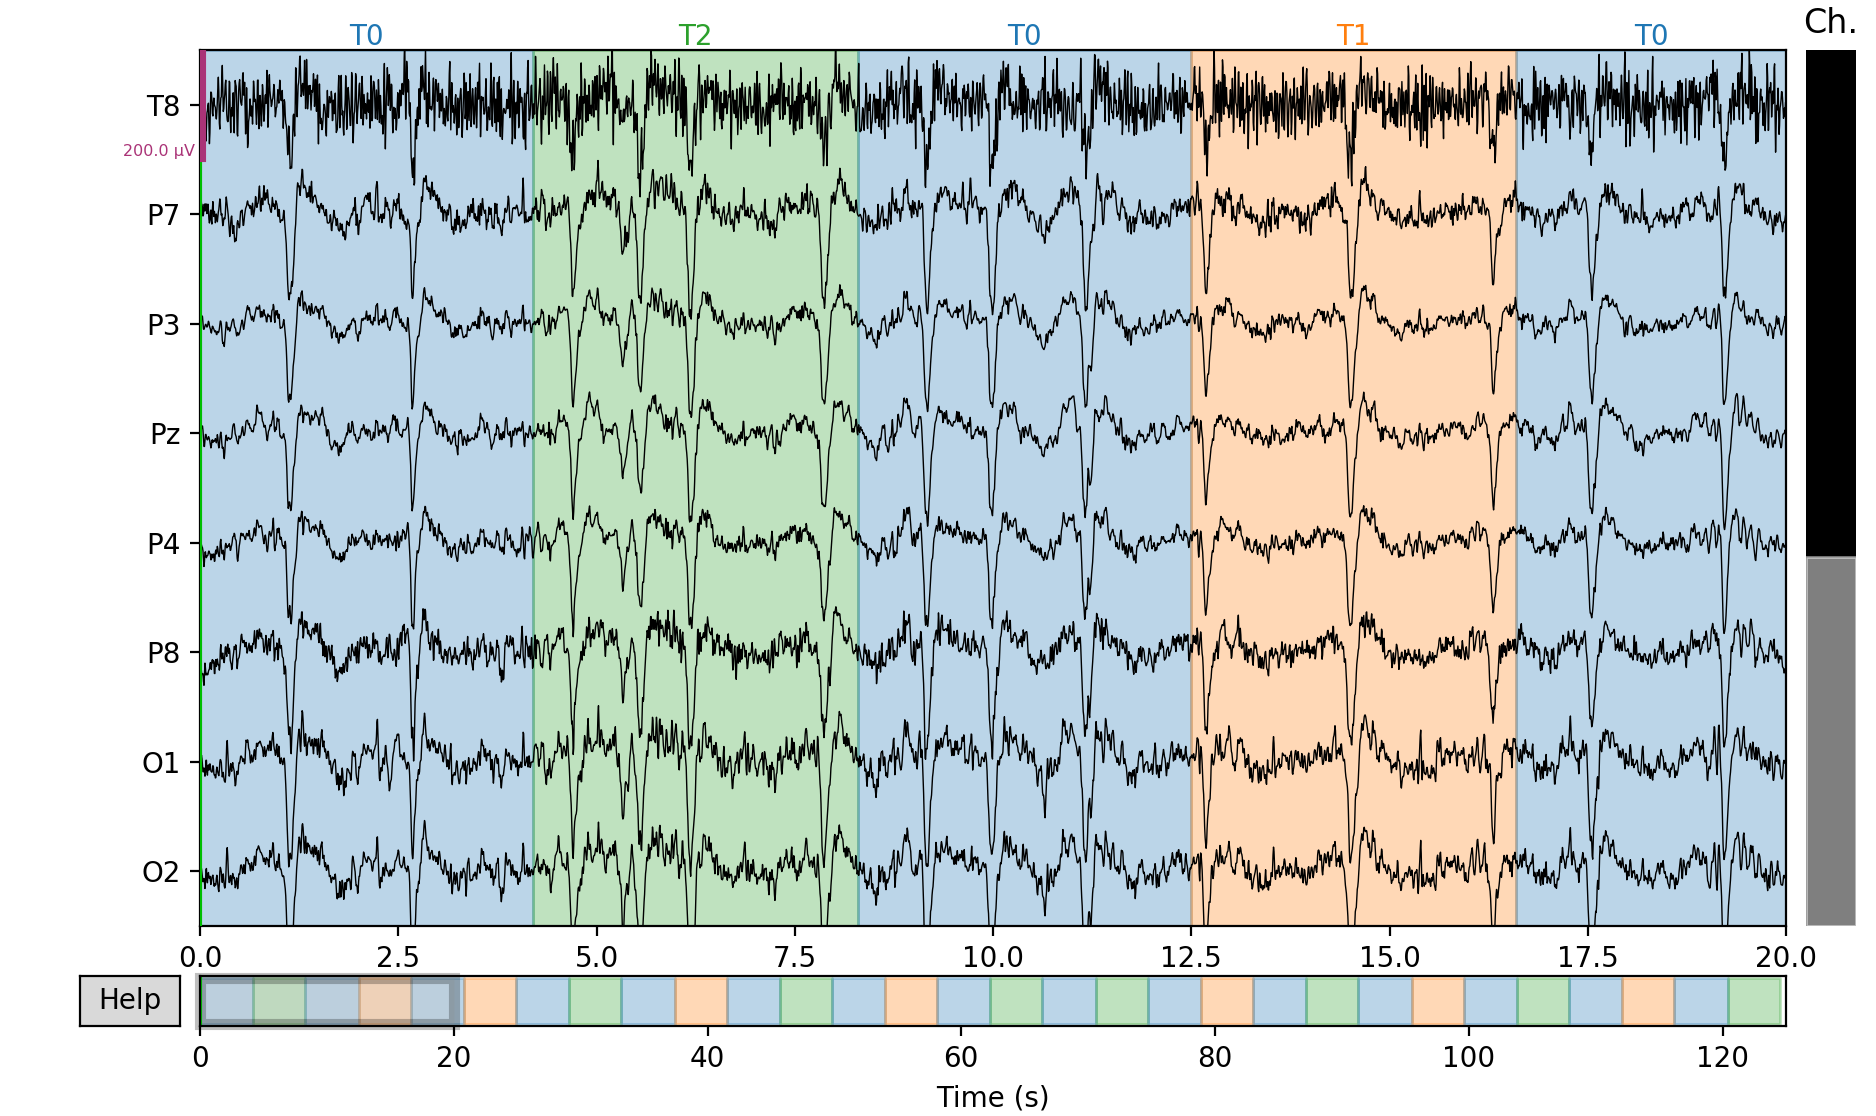

In [200]:
# Plot in better scale. Use 'scaling' argument

# Your code here

sample_1020.plot(n_channels=8, scalings={'eeg':1e-4}, duration=20);

## Extracting events

Mne has several functions for event selection. 

* `mne.find_events` is used when events are stored in trigger channels (e.g. FIFF format)
* `mne.events_from_annotations` is used for when events are stored in annotations (EDF+ format)
    
Look for documentation for your EEG-record format

Here we have EDF+ format

In [201]:
events, events_dict = mne.events_from_annotations(sample_1020)

epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))

Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 209 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  

PSD on epochs differs from the raw. More averaging is used

## Independent Component Analysis for Artifact Removal

In [202]:
n_components = 15

ica_epochs = mne.preprocessing.ICA(n_components=n_components, random_state=42)
ica_epochs.fit(epochs)
ica_src = ica_epochs.get_sources(sample_1020)

channels_to_use = [ch.lower() for ch in ica_epochs.info['ch_names']]

ica_src_df = ica_epochs.get_sources(epochs).to_data_frame()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Fitting ICA took 0.3s.


/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [207]:
ica_epochs.get_sources(epochs).to_data_frame()

,time,condition,epoch,ICA000,ICA001,ICA002,ICA003,ICA004,ICA005,ICA006,ICA007,ICA008,ICA009,ICA010,ICA011,ICA012,ICA013,ICA014
0,-500,1,4,-0.370502,-0.327468,0.365918,0.930192,1.049328,0.570720,0.058701,0.002104,1.333824,-0.422320,1.366270,-2.094083,0.884436,0.302461,-0.990713
1,-494,1,4,-0.511654,-0.492681,0.233567,0.861236,1.374128,1.611380,-0.086221,0.581035,0.588936,-0.845963,1.336254,-2.861968,0.655139,-0.141969,-1.225566
2,-488,1,4,-0.773488,0.590955,-0.314233,0.328871,1.902998,1.377113,-0.018199,0.210535,0.455874,-0.933376,0.475884,-1.857378,0.044077,-0.181041,-1.564569
3,-481,1,4,-0.912661,2.108359,-0.739707,-0.046591,1.462733,1.010889,-0.006092,-0.551332,0.862976,-0.717749,0.491975,-1.271207,0.180526,0.104212,-1.446608
4,-475,1,4,-0.969384,2.545164,-0.477169,-0.077394,0.795312,0.964690,-0.134221,-0.802070,0.977197,-0.698991,0.757646,-2.308700,0.977407,0.443454,-0.845336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,775,3,29,-0.060179,1.469619,0.167479,-1.037959,1.027860,-2.440780,0.548568,-0.455608,-0.051747,-0.615353,-0.885312,0.285873,-0.484678,-0.608104,0.825191
1668,781,3,29,0.113778,1.125812,-0.090597,-0.363805,-0.016131,-3.010562,1.503783,-0.163923,-0.626454,-1.406367,-0.747576,-0.491662,-1.450524,-0.289204,0.771446
1669,788,3,29,0.349555,0.740127,0.147856,-0.343976,-0.584963,-3.234939,2.613143,0.771085,-0.510465,-0.794437,-0.539453,-0.937222,-0.904510,0.293702,0.158155
1670,794,3,29,0.342859,0.391714,1.048551,-0.920979,-0.070694,-2.026804,3.263912,2.327302,0.010191,-0.172366,-0.253121,-0.245997,-0.506266,1.089485,0.276565


In [208]:
import mne

In [209]:
mne.__version__

'0.20.4'

In [203]:
import requests

In [314]:
url = 'http://168.119.186.83/api/auth'
# url = 'http://localhost:8000/api/auth'

data = {
    'username': 'gurgen',
    'password': ''
}

r = requests.post(url, data)

In [ ]:
r.json()

In [327]:
url = 'http://168.119.186.83/api/data/ic'
# url = 'http://localhost:8000/api/data/ic'

data_base = {
    "subject": "S7",
    "dataset": "test_physionet",
    "sfreq": 160.0,
}

In [320]:
token = ''
headers = {'Authorization': "Token {}".format(token)}

In [295]:
r = requests.get('http://localhost:8000/api/data/user-annotation-by-ic/1', json={}, headers=headers)

In [296]:
r.json()

{}

In [328]:
for ic_idx in range(n_components):
    df_weights = pd.DataFrame({'ch_name': channels_to_use, 
                               'value': ica_epochs.get_components()[:, ic_idx]})
    
    col_name = f'ICA{ic_idx:03.0f}'
    df_data = ica_src_df[['epoch', col_name]].rename(columns={col_name: 'value'})
    
    data = data_base.copy()
    
    data.update({
        'name': f'IC{ic_idx:03.0f}',
        'data': {
            'ica_weights': df_weights.to_dict(orient='list'),
            'ica_data': df_data.to_dict(orient='list')
        }
    })
    
    
    r = requests.post(url, json=data, headers=headers)
    
    assert (r.status_code == 201) 